In [1]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
from gym.wrappers.record_video import RecordVideo
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory():
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
    
    # for interacting with environment
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    # for ppo update
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        # action_logprobs indirectly represents the policy $\pi_{\theta}(s,a)$
        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO():
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.ent_coef = 0.01

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory, timestep, total_timestep):   
        # Monte Carlo estimate of state rewards (can be replaced by General Advantage Estimators)
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # learning rate annealing
            frac = (timestep - 1.0) / total_timestep
            new_lr = self.lr * (1.0 - frac)
            new_lr = max(new_lr, 0.0)
            self.optimizer.param_groups[0]["lr"] = new_lr

            # entropy decay
            self.ent_coef = max(0.001, self.ent_coef * (1.0 - frac))

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss (no gradient in advantages)
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            # MseLoss is for the update of critic, dist_entropy denotes an entropy bonus
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - self.ent_coef*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)  # Gradient clipping
            self.optimizer.step()

    
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        




    


learning rate: 0.003 Adam betas: (0.9, 0.999)


c:\Users\lijun\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-0.mp4
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1.mp4
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-8.mp4
Episode 20 	 avg length: 115 	 reward: -187
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-27.mp4
Episode 40 	 avg length: 106 	 reward: -170
Episode 60 	 avg length: 105 	 reward: -138
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-64.mp4
Episode 80 	 avg length: 110 	 reward: -132
Episode 100 	 avg length: 115 	 reward: -106
Episode 120 	 avg length: 108 	 reward: -85
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-125.mp4
Episode 140 	 avg length: 105 	 reward: -97
Episode 160 	 avg length: 105 	 reward: -84
Episode 180 	 avg length: 114 	 reward: -68
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-188.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-188.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-188.mp4
Episode 200 	 avg length: 119 	 reward: -84
Episode 220 	 avg length: 113 	 reward: -62
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-216.mp4
Episode 240 	 avg length: 139 	 reward: -100
Episode 260 	 avg length: 128 	 reward: -58
Episode 280 	 avg length: 137 	 reward: -31
Episode 300 	 avg length: 234 	 reward: -46
Episode 320 	 avg length: 154 	 reward: -18
Episode 340 	 avg length: 369 	 reward: -42
Episode 360 	 avg length: 617 	 reward: -21
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-343.mp4
Episode 380 	 avg length: 780 	 reward: 32
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-365.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-365.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-365.mp4
Episode 400 	 avg length: 666 	 reward: 39
Episode 420 	 avg length: 426 	 reward: -71
Episode 440 	 avg length: 280 	 reward: -55
Episode 460 	 avg length: 202 	 reward: 35
Episode 480 	 avg length: 318 	 reward: 25
Episode 500 	 avg length: 499 	 reward: 17
Episode 520 	 avg length: 471 	 reward: -7
Episode 540 	 avg length: 434 	 reward: 24
Episode 560 	 avg length: 467 	 reward: 64
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-512.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-512.mp4
Episode 580 	 avg length: 548 	 reward: 100
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-528.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-528.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-528.mp4
Episode 600 	 avg length: 573 	 reward: 148
Episode 620 	 avg length: 499 	 reward: 176
Episode 640 	 avg length: 549 	 reward: 154
Episode 660 	 avg length: 592 	 reward: 152
Episode 680 	 avg length: 555 	 reward: 133
Episode 700 	 avg length: 999 	 reward: 144
Episode 720 	 avg length: 456 	 reward: 195
Episode 740 	 avg length: 559 	 reward: 178
Episode 760 	 avg length: 470 	 reward: 148
Episode 780 	 avg length: 328 	 reward: 158
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-688.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-688.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-688.mp4
Episode 800 	 avg length: 335 	 reward: 192
Episode 820 	 avg length: 363 	 reward: 180
Episode 840 	 avg length: 339 	 reward: 198
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-729.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-729.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-729.mp4
Episode 860 	 avg length: 339 	 reward: 162
Episode 880 	 avg length: 399 	 reward: 197
Episode 900 	 avg length: 299 	 reward: 199
Episode 920 	 avg length: 334 	 reward: 205
Episode 940 	 avg length: 295 	 reward: 159
Episode 960 	 avg length: 313 	 reward: 195
Episode 980 	 avg length: 304 	 reward: 185
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-855.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-855.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-855.mp4
Episode 1000 	 avg length: 327 	 reward: 213
Episode 1020 	 avg length: 297 	 reward: 217
Episode 1040 	 avg length: 314 	 reward: 206
Episode 1060 	 avg length: 303 	 reward: 177
Episode 1080 	 avg length: 299 	 reward: 207
Episode 1100 	 avg length: 361 	 reward: 203
Episode 1120 	 avg length: 385 	 reward: 182
Episode 1140 	 avg length: 340 	 reward: 174
Episode 1160 	 avg length: 277 	 reward: 205
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1000.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1000.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1000.mp4
Episode 1180 	 avg length: 257 	 reward: 218
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1024.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1024.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1024.mp4
Episode 1200 	 avg length: 269 	 reward: 227
Episode 1220 	 avg length: 248 	 reward: 219
Episode 1240 	 avg length: 250 	 reward: 233
Episode 1260 	 avg length: 250 	 reward: 240
Episode 1280 	 avg length: 258 	 reward: 219
Episode 1300 	 avg length: 255 	 reward: 221
Episode 1320 	 avg length: 232 	 reward: 221
Episode 1340 	 avg length: 236 	 reward: 244
Episode 1360 	 avg length: 222 	 reward: 234
Episode 1380 	 avg length: 237 	 reward: 228
Moviepy - Building video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1200.mp4.
Moviepy - Writing video c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1200.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\lijun\Desktop\MSc Sem2\Reinforcement Learning\CW2\rl-group-assignment\PPO_testing\PPO_for_discrete\videos\test-video-episode-1200.mp4
Episode 1400 	 avg length: 234 	 reward: 242
Episode 1420 	 avg length: 225 	 reward: 212
Episode 1440 	 avg length: 220 	 reward: 226
Episode 1460 	 avg length: 215 	 reward: 231
Episode 1480 	 avg length: 221 	 reward: 245
Episode 1500 	 avg length: 223 	 reward: 239


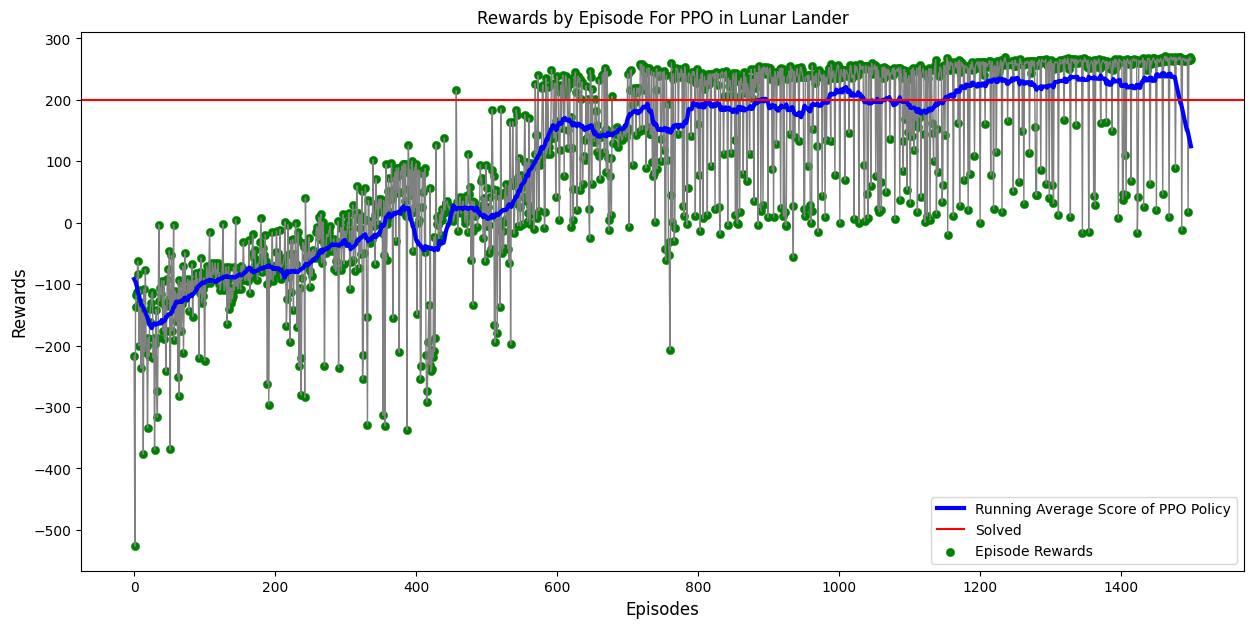

In [3]:

############## Hyperparameters ##############
env_name = "LunarLander-v2"
# creating environment
env = gym.make(env_name, render_mode="rgb_array")
env = RecordVideo(env=env, video_folder="./videos", name_prefix="test-video")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
render = False
solved_reward = 230         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 1500        # max training episodes
max_timesteps = 1000         # max timesteps in one episode
n_latent_var = 256           # number of variables in hidden layer
update_timestep = 2000      # update policy every n timesteps; batch timesteps
lr = 0.003
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 8                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
random_seed = 42
#############################################

# if random_seed:
#     torch.manual_seed(random_seed)
#     env.seed(random_seed)

memory = Memory()
ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
print('learning rate:',lr, 'Adam betas:', betas)

# logging variables
running_reward = 0
avg_length = 0
timestep = 0

rew_for_plots = 0
rew_for_plots_list = []
total_timestep = max_episodes * max_timesteps
# training loop
for i_episode in range(1, max_episodes+1):
    state = env.reset(seed=random_seed)[0]
    
    if i_episode % 200 == 0:
        env.start_video_recorder()

    for t in range(max_timesteps):
        timestep += 1
        
        # Running policy_old:
        # also append state, action, action_logprobs to the memory
        with torch.no_grad():
            action = ppo.policy_old.act(state, memory)
        state, reward, done, truncated, _ = env.step(action)
        
        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory, timestep, total_timestep)
            memory.clear_memory()
            timestep = 0
            break
        
        running_reward += reward
        rew_for_plots += reward

        # if render:
        #     env.render()
        if done or truncated:
            break
    
    if i_episode % 200 == 0:
        env.close_video_recorder()

    avg_length += t
    rew_for_plots_list.append(rew_for_plots)
    rew_for_plots = 0

    
    # stop training if avg_reward > solved_reward
    # if running_reward > (log_interval*solved_reward):
    #     print("########## Solved! ##########")
    #     break

    if timestep >= total_timestep:
        break
    
    # logging
    if i_episode % log_interval == 0:
        avg_length = int(avg_length/log_interval)
        running_reward = int((running_reward/log_interval))
        # print(rew_for_plots)
        print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))
        running_reward = 0
        avg_length = 0

    


# def running_mean(x):
#     N=50
#     kernel = np.ones(N)
#     conv_len = x.shape[0]-N
#     y = np.zeros(conv_len)
#     for i in range(conv_len):
#         y[i] = kernel @ x[i:i+N]
#         y[i] /= N
#     return y


def running_mean(x, N=50):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

rew_for_plots_list = np.array(rew_for_plots_list)
avg_score = running_mean(rew_for_plots_list)
# episode_rewards_history_rand = np.array(episode_rewards_history_rand)  # random agent
# avg_score_rand = running_mean(episode_rewards_history_rand)

plt.figure(figsize=(15,7))
plt.ylabel("Rewards",fontsize=12)
plt.xlabel("Episodes",fontsize=12)
plt.plot(rew_for_plots_list, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3,label = 'Running Average Score of PPO Policy')
# plt.plot(avg_score_rand, color='orange', linewidth=3,label = 'Running Average Score of Random Policy')
plt.axhline(y=200, color='r', linestyle='-',label = 'Solved')
plt.scatter(np.arange(rew_for_plots_list.shape[0]),rew_for_plots_list, 
            color='green' , linewidth=0.3, label='Episode Rewards')
plt.legend()

plt.title('Rewards by Episode For PPO in Lunar Lander')
plt.show()

In [5]:
import pickle
# Serializing the list
with open('list_name.pkl', 'wb') as f:
    pickle.dump(rew_for_plots_list, f)

# Deserializing the list
with open('list_name.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

print(len(loaded_list))

1500
